In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt
import os
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

# Analyzing the flexible path length simulation

Load the file, and from the file pull our the engine (which tells us what the timestep was) and the move scheme (which gives us a starting point for much of the analysis).

In [2]:
filename = "tps_nc_files/alanine_dipeptide_tps.nc"

In [3]:
%%time
flexible = paths.AnalysisStorage(filename)

CPU times: user 38.2 s, sys: 7.33 s, total: 45.6 s
Wall time: 4min 55s


In [4]:
engine = flexible.engines[0]
flex_scheme = flexible.schemes[0]

In [5]:
print "File size: {0} for {1} steps, {2} snapshots".format(
    flexible.file_size_str,
    len(flexible.steps),
    len(flexible.snapshots)
)

File size: 17.25GB for 10001 steps, 922214 snapshots


In [6]:
# rough estimate of total time
sum(step.change.details.timing for step in flexible.steps[1:])

37469.49922776222

That tell us a little about the file we're dealing with. Now we'll start analyzing the contents of that file. We used a very simple move scheme (only shooting), so the main information that the `move_summary` gives us is the acceptance of the only kind of move in that scheme. See the MSTIS examples for more complicated move schemes, where you want to make sure that frequency at which the move runs is close to what was expected.

In [7]:
flex_scheme.move_summary(flexible.steps)

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 5649/10000 (56.49%)


#### Replica history tree and decorrelated trajectories

The `ReplicaHistoryTree` object gives us both the history tree (often called the "move tree") and the number of decorrelated trajectories.

A `ReplicaHistoryTree` is made for a certain set of Monte Carlo steps. First, we make a tree of only the first 50 steps in order to visualize it. (All 10000 steps would be unwieldy.) 

After the visualization, we make a second `ReplicaHistoryTree` of all the steps, in order to count the number of decorrelated trajectories.

In [8]:
history = ops_vis.ReplicaHistoryTree(
    storage=flexible,
    steps=flexible.steps[0:50],
    replica=0
)

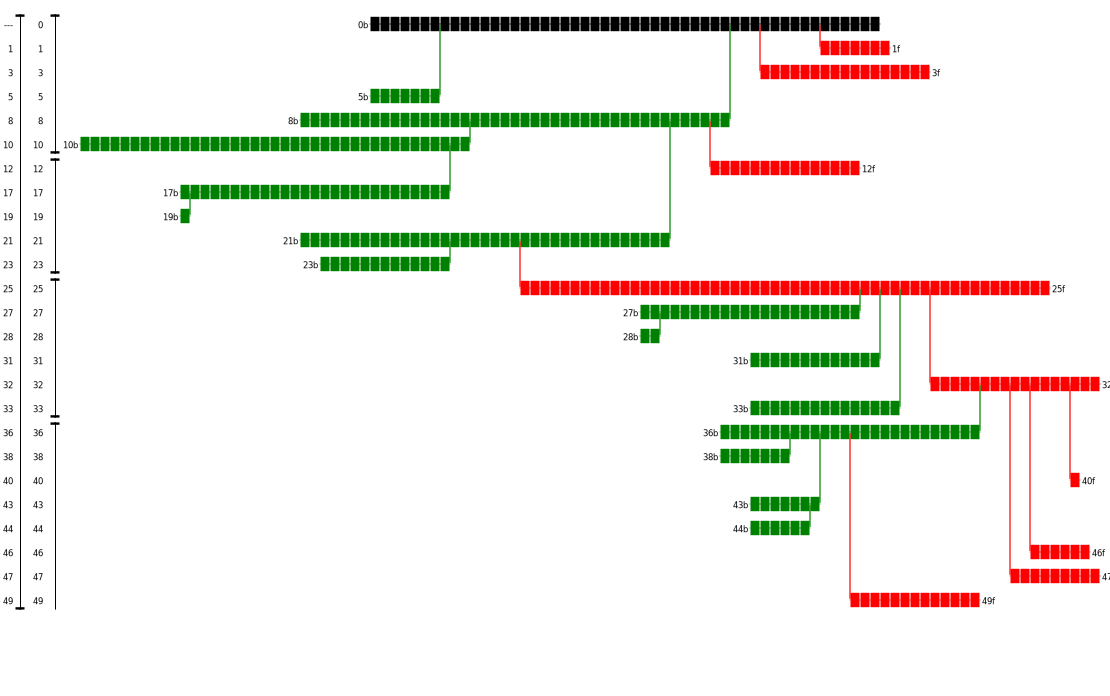

In [9]:
history.view.zoom = 1.0
history.view.scale_y = 24
history.view.scale_x = 10
history.view.font_size = 0.35
history.view.horizontal_gap = 0.05

SVG(history.view.to_svg())

In [10]:
%%time
#full_history = ops_vis.ReplicaHistoryTree(
#    storage=flexible,
#    steps=flexible.steps[0:len(flexible.steps)],
#    replica=0
#)
#print "Decorrelated trajectories:", len(full_history.decorrelated_trajectories)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


#### Path length distribution

Flexible length TPS gives a distribution of path lengths. Here we calculate the length of every accepted trajectory, then histogram those lengths, and calculate the maximum and average path lengths.

We also use `engine.snapshot_timestep` to convert the count of frames to time, including correct units.

Maximum: 392 (7.84 ps)
Average: 78.22 (1.564 ps)


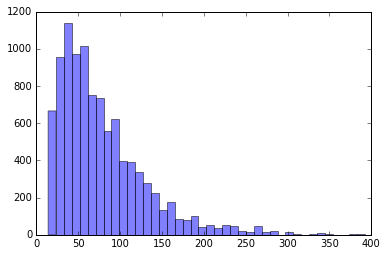

In [11]:
path_lengths = [len(step.active[0].trajectory) for step in flexible.steps]
plt.hist(path_lengths, bins=40, alpha=0.5);
print "Maximum:", max(path_lengths), "("+str(max(path_lengths)*engine.snapshot_timestep)+")"
print "Average:", "{0:.2f}".format(np.mean(path_lengths)), "("+(np.mean(path_lengths)*engine.snapshot_timestep).format("%.3f")+")"

#### Path density histogram

Next we will create a path density histogram. Calculating the histogram itself is quite easy: first we reload the collective variables we want to plot it in (we choose the phi and psi angles). Then we create the empty path density histogram, by telling it which CVs to use and how to make the histogram (bin sizes, etc). Finally, we build the histogram by giving it the list of active trajectories to histogram.

In [12]:
psi = flexible.cvs['psi']
phi = flexible.cvs['phi']
deg = 180.0 / np.pi

In [13]:
path_density = paths.PathDensityHistogram(cvs=[phi, psi],
                                          left_bin_edges=(-180/deg,-180/deg),
                                          bin_widths=(1.0/deg,1.0/deg))

In [14]:
%%time
path_dens_counter = path_density.histogram([s.active[0].trajectory for s in flexible.steps[::10]])
# TODO: for the real then, run over *all* steps -- just takes 10 times longer

CPU times: user 1min 25s, sys: 216 ms, total: 1min 25s
Wall time: 1min 25s


Now we've built the path density histogram, and we want to visualize it. We have a convenient `plot_2d_histogram` function that works in this case, and takes the histogram, desired plot tick labels and limits, and additional `matplotlib` named arguments to `plt.pcolormesh`.

Although the labels are given in radians, the internal plotting is in bin numbers. Therefore, we need to convert the trajectories 

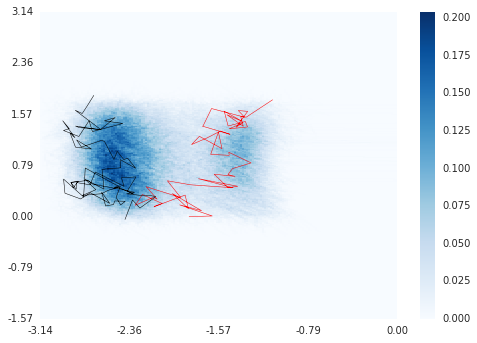

In [218]:
from openpathsampling.analysis import plot_2d_histogram
tick_labels = np.arange(-np.pi, np.pi+0.01, np.pi/4.0)
ax = plot_2d_histogram(path_density,
                       xticklabels=tick_labels,
                       yticklabels=tick_labels,
                       xlim=(-np.pi, 0),
                       ylim=(-np.pi/2, np.pi),
                       cmap="Blues")
trajA = flexible.steps[1000].active[0].trajectory
xA, yA = hist_fcn.plottable_2d(phi(trajA), psi(trajA))
plt.plot(xA, yA, '-r', lw=0.5)
trajB = flexible.steps[2000].active[0].trajectory
xB, yB = hist_fcn.plottable_2d(phi(trajB), psi(trajB))
plt.plot(xB, yB, '-k', lw=0.5);

In [184]:
reload(paths.analysis.histogram)
reload(paths.analysis.lookup_function)
reload(paths.analysis)
reload(paths)


<module 'openpathsampling' from '/Users/dwhs/Dropbox/msm-tis/openpathsampling/__init__.pyc'>

In [185]:
hist_fcn = path_density.normalized(raw_probability=True)

In [186]:
df = hist_fcn.df_2d(bin_numbers=False)

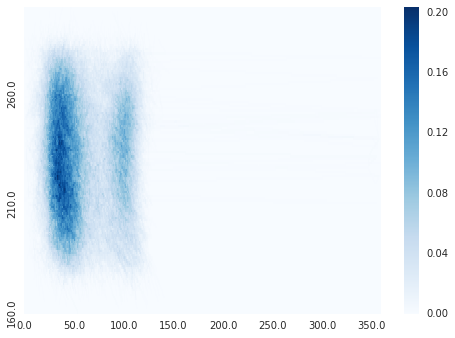

In [187]:
import seaborn as sb
ax = sb.heatmap(df.fillna(0.0).transpose(), xticklabels=50, yticklabels=50, cmap="Blues")
ax.invert_yaxis()

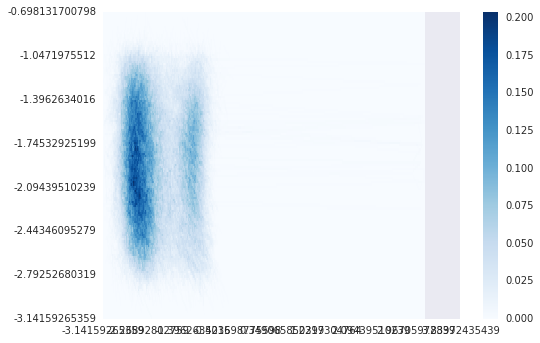

In [144]:
mesh = plt.pcolormesh(df.fillna(0.0).transpose(), cmap="Blues")
mesh.axes.set_xticklabels([hist_fcn.bin_to_left_edge((n, 0))[0] for n in mesh.axes.get_xticks()])
mesh.axes.set_yticklabels([hist_fcn.bin_to_left_edge((0, n))[1] for n in mesh.axes.get_yticks()])
plt.colorbar()

In [118]:
list(df.index[::50])

[-3.1415926535897931,
 -2.2689280275926285,
 -1.3962634015954636,
 -0.5235987755982987,
 0.34906585039886595,
 1.2217304763960311,
 2.0943951023931957,
 2.9670597283903604]

In [22]:
hist_fcn.keys()

[(87.0, 229.0),
 (110.0, 190.0),
 (312.0, 241.0),
 (111.0, 227.0),
 (170.0, 243.0),
 (30.0, 287.0),
 (52.0, 243.0),
 (39.0, 171.0),
 (128.0, 259.0),
 (76.0, 201.0),
 (167.0, 226.0),
 (100.0, 199.0),
 (115.0, 257.0),
 (191.0, 232.0),
 (124.0, 221.0),
 (298.0, 238.0),
 (65.0, 233.0),
 (104.0, 273.0),
 (322.0, 248.0),
 (89.0, 227.0),
 (38.0, 228.0),
 (62.0, 238.0),
 (86.0, 240.0),
 (17.0, 287.0),
 (109.0, 177.0),
 (94.0, 287.0),
 (169.0, 228.0),
 (27.0, 194.0),
 (9.0, 183.0),
 (28.0, 185.0),
 (284.0, 211.0),
 (51.0, 200.0),
 (217.0, 240.0),
 (75.0, 254.0),
 (113.0, 263.0),
 (60.0, 266.0),
 (98.0, 181.0),
 (316.0, 252.0),
 (99.0, 244.0),
 (198.0, 248.0),
 (40.0, 230.0),
 (41.0, 179.0),
 (95.0, 256.0),
 (64.0, 252.0),
 (88.0, 242.0),
 (127.0, 179.0),
 (112.0, 200.0),
 (353.0, 210.0),
 (61.0, 257.0),
 (46.0, 175.0),
 (122.0, 273.0),
 (69.0, 246.0),
 (32.0, 277.0),
 (144.0, 211.0),
 (26.0, 219.0),
 (50.0, 229.0),
 (88.0, 272.0),
 (35.0, 267.0),
 (74.0, 239.0),
 (29.0, 226.0),
 (31.0, 223.0),


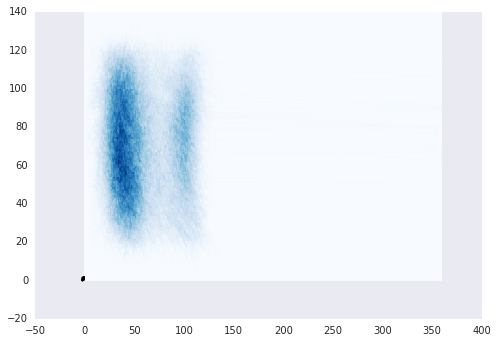

In [148]:
plt.plot(phi(traj100), psi(traj100), '-k')
plt.pcolormesh(df.fillna(0.0).transpose(), cmap="Blues")

In [ ]:
#import nglview as nv
#nv.show_mdtraj(traj.md())

# Analyzing the fixed path length simulation

We start with the same sorts of analysis as we did in the flexible path length example: we get an overview of the file, then we look at the acceptance ratio, and then we look at the move history tree and the decorrelated trajectories.

In [ ]:
%%time
fixed = paths.AnalysisStorage("tps_nc_files/alanine_dipeptide_fixed_tps.nc")

In [ ]:
engine = fixed.engines[0]
fixed_scheme = fixed.schemes[0]

print "File size: {0} for {1} steps, {2} snapshots".format(
    fixed.file_size_str,
    len(fixed.steps),
    len(fixed.snapshots)
)

In [ ]:
# rough estimate of total time
sum(step.change.details.timing for step in fixed.steps[1:])

In [ ]:
fixed_scheme.move_summary(fixed.steps)

In [ ]:
history = ops_vis.ReplicaHistoryTree(
    storage=fixed,
    steps=fixed.steps[0:50],
    replica=0
)

In [ ]:
history.view.zoom = 1.0
history.view.scale_y = 24
history.view.scale_x = 3
history.view.font_size = 0.35
history.view.horizontal_gap = 0.05

SVG(history.view.to_svg())

In [ ]:
full_history = ops_vis.ReplicaHistoryTree(
    storage=fixed,
    steps=fixed.steps[0:len(fixed.steps)],
    replica=0
)
print "Decorrelated trajectories:", len(full_history.decorrelated_trajectories)

Note that the number of MC steps (and even more so, time steps) per decorrelated trajectory is much higher than in the case of flexible path length TPS. This is the heart of the argument that flexible path length approaches are more efficient than fixed path length approaches: with a fixed path length, it takes much more effort to get a decorrelated trajectory.

### Advanced analysis techniques

Now we'll move on to a few more advanced analysis techniques. (These are discussed in Paper II.)

With the fixed path length ensemble, we should check for recrossings. To do this, we create an ensemble which represents the recrossing paths: a frame in $\beta$, possible frames in neither $\alpha$ nor $\beta$, and then a frame in $\alpha$.

Then we check whether any subtrajectory of a trial trajectory matches that ensemble, by using the `Ensemble.split()` function. We can then further refine to see which steps that included trials with recrossings were actually accepted.

In [ ]:
# create the ensemble that identifies recrossings
alpha = fixed.volumes.find('alpha')
beta = fixed.volumes.find('beta')
recrossing_ensemble = paths.SequentialEnsemble([
    paths.LengthEnsemble(1) & paths.AllInXEnsemble(beta),
    paths.OptionalEnsemble(paths.AllOutXEnsemble(alpha | beta)),
    paths.LengthEnsemble(1) & paths.AllInXEnsemble(alpha) 
])

In [ ]:
# now we check each step to see if its trial has a recrossing
steps_with_recrossing = []
for step in fixed.steps:
    # trials is a list of samples: with shooting, only one in the list
    recrossings = [] # default for initial empty move (no trials in step[0].change)
    for trial in step.change.trials:
        recrossings = recrossing_ensemble.split(trial.trajectory)
        # recrossing contains a list with the recrossing trajectories
        # (len(recrossing) == 0 if no recrossings)
    if len(recrossings) > 0:
        steps_with_recrossing += [step]  # save for later analysis

In [ ]:
accepted_recrossings = [step for step in steps_with_recrossing if step.change.accepted is True]

In [ ]:
print "Trials with recrossings:", len(steps_with_recrossing)
print "Accepted trials with recrossings:", len(accepted_recrossings)

Note that the accepted trials with recrossing does not account for how long the trial remained active. It also doesn't tell us whether the trial represented a new recrossing event, or was correlated with the previous recrossing event.

Let's take a look at one of the accepted trajectories with a recrossing event. We'll plot the value of $\psi$, since this is what distinguishes the two states. We'll also select the frames that are actually inside each state and color them (red for $\alpha$, blue for $\beta$).

In [ ]:
psi = fixed.cvs.find('psi')
trajectory = accepted_recrossings[0].active[0].trajectory
in_alpha_indices = [trajectory.index(s) for s in trajectory if alpha(s)]
in_alpha_psi = [psi(trajectory)[i] for i in in_alpha_indices]
in_beta_indices = [trajectory.index(s) for s in trajectory if beta(s)]
in_beta_psi = [psi(trajectory)[i] for i in in_beta_indices]

plt.plot(psi(trajectory), 'k-')
plt.plot(in_alpha_indices, in_alpha_psi, 'ro')  # alpha in red
plt.plot(in_beta_indices, in_beta_psi, 'bo')  # beta in blue

Now let's see how many recrossing events there are in each accepted trial. If there's one recrossing, then the trajectory much go $\alpha\to\beta\to\alpha\to\beta$ to be accepted. Two recrossings would mean $\alpha\to\beta\to\alpha\to\beta\to\alpha\to\beta$.

In [ ]:
recrossings_per = []
for step in accepted_recrossings:
    for test in step.change.trials:
        recrossings_per.append(len(recrossing_ensemble.split(test.trajectory)))

In [ ]:
print recrossings_per

# Comparing the fixed and flexible simulations

In [ ]:
# transition path length distribution
flex_ens = flex_scheme.network.sampling_ensembles[0]
fixed_transition_segments = sum([flex_ens.split(step.active[0].trajectory) for step in fixed.steps],[])
fixed_transition_length = [len(traj) for traj in fixed_transition_segments]

In [ ]:
print len(fixed_transition_length)

In [ ]:
bins = np.linspace(0, 400, 80);
plt.hist(path_lengths, bins, alpha=0.5, normed=True, label="flexible");
plt.hist(fixed_transition_length, bins, alpha=0.5, normed=True, label="fixed");
plt.legend(loc='upper right');

#### Identifying different mechanisms using custom ensembles

We expected the plot above to be very similar for both cases. However, we know that the $\alpha\to\beta$ transition in alanine dipeptide can occur via two mechanisms: since $\psi$ is periodic, the transition can occur due to an overall increase in $\psi$, or due to an overall decrease in $\psi$. We also know that the alanine dipeptide transitions aren't actually all that rare, so they will occur spontaneously in long simulations.


This section shows how to create custom ensembles to identify whether the transition occurred with an increasing $\psi$ or a decreasing $\psi$. We also need to account for (unlikely) edge cases where the path starts in one direction but completes the transition from the other.

First, we'll create a few more `Volume` objects. In this case, we will completely tile the Ramachandran space; while a complete tiling isn't necessary, it is often useful.

In [ ]:
# first, we fully subdivide the Ramachandran space
phi = fixed.cvs.find('phi')
deg = 180.0/np.pi
nml_plus = paths.CVRangeVolumePeriodic(psi, -160/deg, -100/deg, -np.pi, np.pi)
nml_minus = paths.CVRangeVolumePeriodic(psi, 0/deg, 100/deg, -np.pi, np.pi)
nml_alpha = (paths.CVRangeVolumePeriodic(phi, 0/deg, 180/deg, -np.pi, np.pi) &
             paths.CVRangeVolumePeriodic(psi, 100/deg, 200/deg, -np.pi, np.pi))
nml_beta = (paths.CVRangeVolumePeriodic(phi, 0/deg, 180/deg, -np.pi, np.pi) &
            paths.CVRangeVolumePeriodic(psi, -100/deg, 0/deg, -np.pi, np.pi))

In [ ]:
#TODO: plot to display where these volumes are

Next, we'll create ensembles for the "increasing" and "decreasing" transitions. These transitions mark a crossing of either the `nml_plus` or the `nml_minus`. These aren't necessarily $\alpha\to\beta$ transitions. However, any $\alpha\to\beta$ transition must contain at least one subtrajectory which satsifies one of these ensembles.

In [ ]:
increasing = paths.SequentialEnsemble([
    paths.AllInXEnsemble(alpha | nml_alpha),
    paths.AllInXEnsemble(nml_plus),
    paths.AllInXEnsemble(beta | nml_beta)
])
decreasing = paths.SequentialEnsemble([
    paths.AllInXEnsemble(alpha | nml_alpha),
    paths.AllInXEnsemble(nml_minus),
    paths.AllInXEnsemble(beta | nml_beta)
])

Finally, we'll write a little function that characterizes a set of trajectories according to these ensembles. It returns a dictionary mapping the ensemble (`increasing` or `decreasing`) to a list of trajectories that have a subtrajectory that satisfies it (at least one entry in `ensemble.split(trajectory)`). That dictionary also contains keys for `'multiple'` matched ensembles and `None` if no ensemble was matched. Trajectories for either of these keys would need to be investigated further.

In [ ]:
def categorize_transitions(ensembles, trajectories):
    results = {ens : [] for ens in ensembles + ['multiple', None]}
    for traj in trajectories:
        matched_ens = None
        for ens in ensembles:
            if len(ens.split(traj)) > 0:
                if matched_ens is not None:
                    matched_ens = 'multiple'
                else:
                    matched_ens = ens
        results[matched_ens].append(traj)
    return results

With that function defined, let's use it!

In [ ]:
categorized = categorize_transitions(ensembles=[increasing, decreasing],
                                     trajectories=fixed_transition_segments)

In [ ]:
print "increasing:", len(categorized[increasing])
print "decreasing:", len(categorized[decreasing])
print "  multiple:", len(categorized['multiple'])
print "      None:", len(categorized[None])

Comparing to the flexible length simulation:

In [ ]:
flex_trajs = [step.active[0].trajectory for step in flexible.steps]
flex_categorized = categorize_transitions(ensembles=[increasing, decreasing],
                                          trajectories=flex_trajs[::10])

In [ ]:
print "increasing:", len(flex_categorized[increasing])
print "decreasing:", len(flex_categorized[decreasing])
print "  multiple:", len(flex_categorized['multiple'])
print "      None:", len(flex_categorized[None])

So the fixed length sampling is somehow capturing both kinds of transitions (probably because they are not really that rare). Let's see what the path length distribution from only the decreasing transitions looks

In [ ]:
plt.hist([len(traj) for traj in flex_categorized[decreasing]], bins, alpha=0.5, normed=True);
plt.hist([len(traj) for traj in categorized[decreasing]], bins, alpha=0.5, normed=True);

Still a little off, although this might be due to bad sampling. Let's see how many of the decorrelated trajectories have this kind of transition.

In [ ]:
# start with the decorrelated tragectories
fixed_decorrelated = full_history.decorrelated_trajectories
# find the A->B transitions from the decorrelated trajectories
decorrelated_transitions = sum([flex_ens.split(traj) for traj in fixed_decorrelated], [])
# find the A->B transition from these which are decreasing
decorrelated_decreasing = sum([decreasing.split(traj) for traj in decorrelated_transitions], [])
print len(decorrelated_decreasing)

So this is based off of 11 decorrelated trajectory transitions. That's not a lot of statistics.

However, we expect to see a *very* different distribution for the "increasing" paths:

In [ ]:
plt.hist([len(traj) for traj in categorized[increasing]], bins, normed=True, alpha=0.5, color='g');

Let's also check whether we go back and forth between the increasing transition and the decreasing transition, or whether there's just a single change from one type to the other.

In [ ]:
def find_switches(ensembles, trajectories):
    switches = []
    last_category = None
    traj_num = 0
    for traj in trajectories:
        category = None
        for ens in ensembles:
            if len(ens.split(traj)) > 0:
                if category is not None:
                    category = 'multiple'
                else:
                    category = ens
        if last_category != category:
            switches.append((category, traj_num))
        traj_num += 1
        last_category = category
    return switches

In [ ]:
switches = find_switches([increasing, decreasing], fixed_transition_segments)

In [ ]:
print [switch[1] for switch in switches], len(fixed_transition_segments)

So there are a lot of switches early in the simulation, and then it gets stuck in one state for much longer.

Even though we know the alanine dipeptide transitions are not particularly rare, this does give us reason to re-check the temperature. First we'll check what the intergrator says its temperature is, then we'll calculate the temperature based on the kinetic energy of every 50th trajectory.

Note that the code below is specific to using the OpenMM engine.

In [ ]:
print engine.integrator.getTemperature()

In [ ]:
every_50th_trajectory = [step.active[0].trajectory for step in fixed.steps[::50]]

In [ ]:
# make a set to remove duplicates, if trajs aren't decorrelated
every_50th_traj_snapshots = list(set(sum(every_50th_trajectory, [])))
# sadly, it looks like that trick with set doesn't do any good here

In [ ]:
# this is ugly as sin: we need a better way of doing it (ideally as a snapshot feature)

# dof calculation taken from OpenMM's StateDataReporter
import simtk.openmm as mm
import simtk.unit
dof = 0
system = engine.simulation.system
dofs_from_particles = 0
for i in range(system.getNumParticles()):
    if system.getParticleMass(i) > 0*simtk.unit.dalton:
        dofs_from_particles += 3
dofs_from_constraints = system.getNumConstraints()
dofs_from_motion_removers = 0
if any(type(system.getForce(i)) == mm.CMMotionRemover for i in range(system.getNumForces())):
    dofs_from_motion_removers += 3
dof = dofs_from_particles - dofs_from_constraints - dofs_from_motion_removers
#print dof, "=", dofs_from_particles, "-", dofs_from_constraints, "-", dofs_from_motion_removers

kinetic_energies = []
potential_energies = []
temperatures = []
R = simtk.unit.BOLTZMANN_CONSTANT_kB * simtk.unit.AVOGADRO_CONSTANT_NA
for snap in every_50th_traj_snapshots:
    engine.current_snapshot = snap
    state = engine.simulation.context.getState(getEnergy=True)
    ke = state.getKineticEnergy()
    temperatures.append(2 * ke / dof / R)

In [ ]:
plt.plot([T / T.unit for T in temperatures])
mean_T = np.mean(temperatures)
plt.plot([mean_T / mean_T.unit]*len(temperatures), 'r')
print "Mean temperature:", np.mean(temperatures).format("%.2f")

While this is running a little hot, it is reasonable, and definitely not hot enough to blame for unexpected rare events.